In [ ]:

import gensim
import keras
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder

import pandas as pd

np.random.seed(1003)

Using TensorFlow backend.


In [ ]:
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
DATA_DIR = ''
Glove = 'glove.6B.100d.txt'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 170
MAX_VOCAB_SIZE = 400000
LSTM_DIM = 128
EMBEDDING_DIM = 100
BATCH_SIZE = 200
N_EPOCHS = 10

In [ ]:
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

In [ ]:
train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [ ]:
train.replace('unrelated',1,True)
train.replace('agree',2,True)
train.replace('disagree',3,True)
train.replace('discuss',4,True)

In [ ]:
word_seq_headline_train = [text_to_word_sequence(sent) for sent in train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(sent) for sent in train['articleBody']]

word_seq_headline_test = [text_to_word_sequence(sent) for sent in test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(sent) for sent in test['articleBody']]

In [ ]:
word_seq = []
for i in range(len(word_seq_headline_train)):
  word_seq.append(word_seq_headline_train[i])
  
for i in range(len(word_seq_bodies_train)):
  word_seq.append(word_seq_bodies_train[i])

for i in range(len(word_seq_headline_test)):
  word_seq.append(word_seq_headline_test[i])

for i in range(len(word_seq_bodies_test)):
  word_seq.append(word_seq_bodies_test[i])

In [ ]:
for i in range (len(word_seq_headline_train)):
  word_seq_headline_train[i].extend(word_seq_bodies_train[i])

  
for i in range (len(word_seq_headline_test)):
  word_seq_headline_test[i].extend(word_seq_bodies_test[i])

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

In [ ]:
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = train['Stance']
y_train = y_train.values


In [ ]:
from keras.utils import np_utils

encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.100d.txt", word2vec_output_file="gensim_glove_vectors.txt")

(400000, 100)

In [ ]:
#glove2word2vec(glove_input_file=Glove, word2vec_output_file="gensim_glove_vectors.txt")
embeddings = gensim.models.KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [ ]:

from keras.optimizers import Adam
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, MaxPooling1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
model_conv = Sequential()
model_conv.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer'
                          ))
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_conv.add(Dense(4, activation='sigmoid'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_conv.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 100)         2238100   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 2,468,824
Trainable params: 230,724
Non-trainable params: 2,238,100
______________________________________

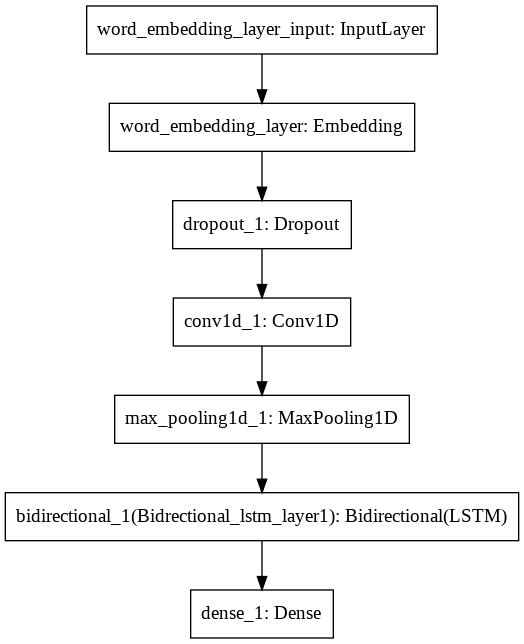

In [ ]:
keras.utils.plot_model(model_conv, show_shapes=False)

In [ ]:
history = model_conv.fit(X_train, y_train,
          batch_size=100,
          epochs=20,
          validation_data=(X_val, y_val))


Train on 44974 samples, validate on 4998 samples
Epoch 1/20
44974/44974 [==============================] - 156s 3ms/step - loss: 0.7478 - accuracy: 0.7317 - val_loss: 0.6739 - val_accuracy: 0.7287
Epoch 2/20
44974/44974 [==============================] - 154s 3ms/step - loss: 0.6335 - accuracy: 0.7497 - val_loss: 0.5797 - val_accuracy: 0.7661
Epoch 3/20
44974/44974 [==============================] - 155s 3ms/step - loss: 0.5366 - accuracy: 0.7854 - val_loss: 0.5224 - val_accuracy: 0.7863
Epoch 4/20
44974/44974 [==============================] - 157s 3ms/step - loss: 0.4567 - accuracy: 0.8202 - val_loss: 0.4206 - val_accuracy: 0.8371
Epoch 5/20
44974/44974 [==============================] - 154s 3ms/step - loss: 0.3932 - accuracy: 0.8460 - val_loss: 0.3651 - val_accuracy: 0.8605
Epoch 6/20
44974/44974 [==============================] - 154s 3ms/step - loss: 0.3477 - accuracy: 0.8652 - val_loss: 0.3335 - val_accuracy: 0.8747
Epoch 7/20
44974/44974 [==============================] - 155s 

In [ ]:
from keras.models import load_model

model_conv.save('BILSTMCNN_W2V.h5')

In [ ]:
with open('CNNBILSTM_glove', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

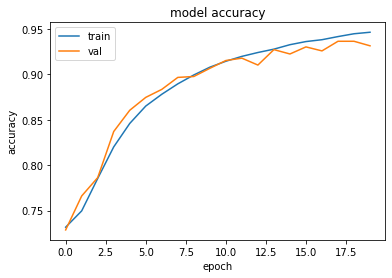

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.savefig("1.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

competetion_unlabeled = pd.read_csv(DATA_DIR+'competition_test_stances_unlabeled.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')

comp.replace('unrelated',1,True)
comp.replace('agree',2,True)
comp.replace('disagree',3,True)
comp.replace('discuss',4,True)

word_seq_headline_comp = [text_to_word_sequence(sent) for sent in comp['Headline']]
word_seq_bodies_comp = [text_to_word_sequence(sent) for sent in comp['articleBody']]

for i in range (len(word_seq_headline_comp)):
  word_seq_headline_comp[i].extend(word_seq_bodies_comp[i])

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])

X_comp = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_comp = pad_sequences(X_comp, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_comp = comp['Stance']
y_comp = y_comp.values


encoder_comp = LabelEncoder()
encoder_comp.fit(y_comp)
encoded_comp = encoder_comp.transform(y_comp)
dummy_y_comp = np_utils.to_categorical(encoded_comp)

y_Uni = model_conv.predict(X_comp)
score,acc = model_conv.evaluate(X_comp, dummy_y_comp)

25413/25413 [==============================] - 25s 973us/step


In [ ]:
from score import report_score
outputs = [np.argmax(p) for p in y_Uni]

for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "agree"
    if outputs[i] == 3: outputs[i] = "discuss"
#print (np.unique(outputs))

cs = pd.read_csv(DATA_DIR+'competition_test_stances.csv')
stance_true = cs['Stance'].values
from score import report_score
print ("Weighted Score")
report_score(stance_true, outputs)

Predicted = {}
Predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([competetion_unlabeled, Predicted], axis=1, sort=False)
result.to_csv('CNN_glove_BILSTM.csv', index=False, encoding='utf-8')

Weighted Score
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     4     |    469    |    237    |   1193    |
-------------------------------------------------------------
| disagree  |     0     |    194    |    64     |    439    |
-------------------------------------------------------------
|  discuss  |    18     |   1660    |    423    |   2363    |
-------------------------------------------------------------
| unrelated |    58     |   4866    |   1698    |   11727   |
-------------------------------------------------------------
Score: 4164.75 out of 11651.25	(35.74509172835533%)
